In [54]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# -----------------------------
# STEP 1: Load and preprocess
# -----------------------------
df = pd.read_csv("/Users/Intel/Desktop/spring 2025/CAPSTONE/cleaned_data.csv")
df["FIRST_OCCURRENCE_DATE"] = pd.to_datetime(df["FIRST_OCCURRENCE_DATE"], errors='coerce')
df = df[df["NEIGHBORHOOD_ID"].notnull()]
df["DATE"] = df["FIRST_OCCURRENCE_DATE"].dt.date

# -----------------------------
# STEP 2: Daily Neighborhood Aggregation
# -----------------------------
daily_crime = (
    df.groupby(["DATE", "NEIGHBORHOOD_ID", "GEO_LAT", "GEO_LON"])
    .size()
    .reset_index(name="crime_count")
    .sort_values(by=["NEIGHBORHOOD_ID", "DATE"])
)

# -----------------------------
# STEP 3: Lag and rolling features
# -----------------------------
def add_features(group):
    group = group.sort_values("DATE")
    group["lag1"] = group["crime_count"].shift(1)
    group["lag3"] = group["crime_count"].shift(3)
    group["rolling_mean_7"] = group["crime_count"].rolling(window=7).mean()
    return group

daily_crime = daily_crime.groupby("NEIGHBORHOOD_ID").apply(add_features).reset_index(drop=True)
daily_crime.dropna(inplace=True)

# -----------------------------
# STEP 4: Feature Setup
# -----------------------------
X = daily_crime[["lag1", "lag3", "rolling_mean_7"]]
y = daily_crime["crime_count"]
meta = daily_crime[["DATE", "NEIGHBORHOOD_ID", "GEO_LAT", "GEO_LON"]]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test, meta_train, meta_test = train_test_split(
    X_scaled, y, meta, test_size=0.2, shuffle=False
)

# -----------------------------
# STEP 5: Train base models
# -----------------------------
rf = RandomForestRegressor(n_estimators=100, random_state=42)
lgb = LGBMRegressor(n_estimators=100, random_state=42)
gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

rf.fit(X_train, y_train)
lgb.fit(X_train, y_train)
gb.fit(X_train, y_train)

pred_rf = rf.predict(X_test)
pred_lgb = lgb.predict(X_test)
pred_gb = gb.predict(X_test)

# -----------------------------
# STEP 6: Meta Model (Stacking)
# -----------------------------
stacked_preds = np.column_stack((pred_rf, pred_lgb, pred_gb))
meta_model = LinearRegression()
meta_model.fit(stacked_preds, y_test)
final_preds = meta_model.predict(stacked_preds)

# -----------------------------
# STEP 7: Evaluation
# -----------------------------
rmse = np.sqrt(mean_squared_error(y_test, final_preds))
mae = mean_absolute_error(y_test, final_preds)
r2 = r2_score(y_test, final_preds)
mape = np.mean(np.abs((y_test - final_preds) / (y_test + 1e-8))) * 100

print(f"✅ RMSE: {rmse:.4f}")
print(f"✅ MAE: {mae:.4f}")
print(f"✅ R² Score: {r2:.4f}")
print(f"✅ MAPE: {mape:.2f}%")

# -----------------------------
# STEP 8: Merge with metadata
# -----------------------------
meta_test = meta_test.reset_index(drop=True)
result_df = pd.concat([meta_test, y_test.reset_index(drop=True)], axis=1)
result_df["predicted_crime_count"] = final_preds

print("\n📊 Sample Output:")
print(result_df.head(10))

# Save to CSV
result_df.to_csv("ensemble_predicted_neighborhood_crime.csv", index=False)


/var/folders/s0/9c8j0gnd1_l2cgnr9wq06b7r0000gn/T/ipykernel_84228/2084695727.py:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_crime = daily_crime.groupby("NEIGHBORHOOD_ID").apply(add_features).reset_index(drop=True)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 70
[LightGBM] [Info] Number of data points in the train set: 275478, number of used features: 3
[LightGBM] [Info] Start training from score 1.137376


/Users/Intel/Desktop/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


✅ RMSE: 0.3650
✅ MAE: 0.1508
✅ R² Score: 0.2266
✅ MAPE: 10.72%

📊 Sample Output:
         DATE NEIGHBORHOOD_ID    GEO_LAT     GEO_LON  crime_count  \
0  2021-08-19      sun-valley  39.735170 -105.022590            1   
1  2021-08-20      sun-valley  39.729586 -105.021259            1   
2  2021-08-21      sun-valley  39.733242 -105.024629            1   
3  2021-08-24      sun-valley  39.742287 -105.017616            1   
4  2021-08-25      sun-valley  39.738005 -105.025152            1   
5  2021-08-28      sun-valley  39.743922 -105.020108            1   
6  2021-08-31      sun-valley  39.728976 -105.022429            2   
7  2021-08-31      sun-valley  39.734922 -105.020437            1   
8  2021-08-31      sun-valley  39.735170 -105.022590            2   
9  2021-09-02      sun-valley  39.735170 -105.022590            1   

   predicted_crime_count  
0               0.998440  
1               0.998440  
2               0.998440  
3               0.998440  
4               0.998440

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load predictions CSV
df = pd.read_csv("/Users/Intel/Desktop/ensemble_predicted_neighborhood_crime.csv")

# Convert DATE to datetime
df["DATE"] = pd.to_datetime(df["DATE"])


/var/folders/s0/9c8j0gnd1_l2cgnr9wq06b7r0000gn/T/ipykernel_84228/2093472622.py:14: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from current font.
  plt.tight_layout()
/Users/Intel/Desktop/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


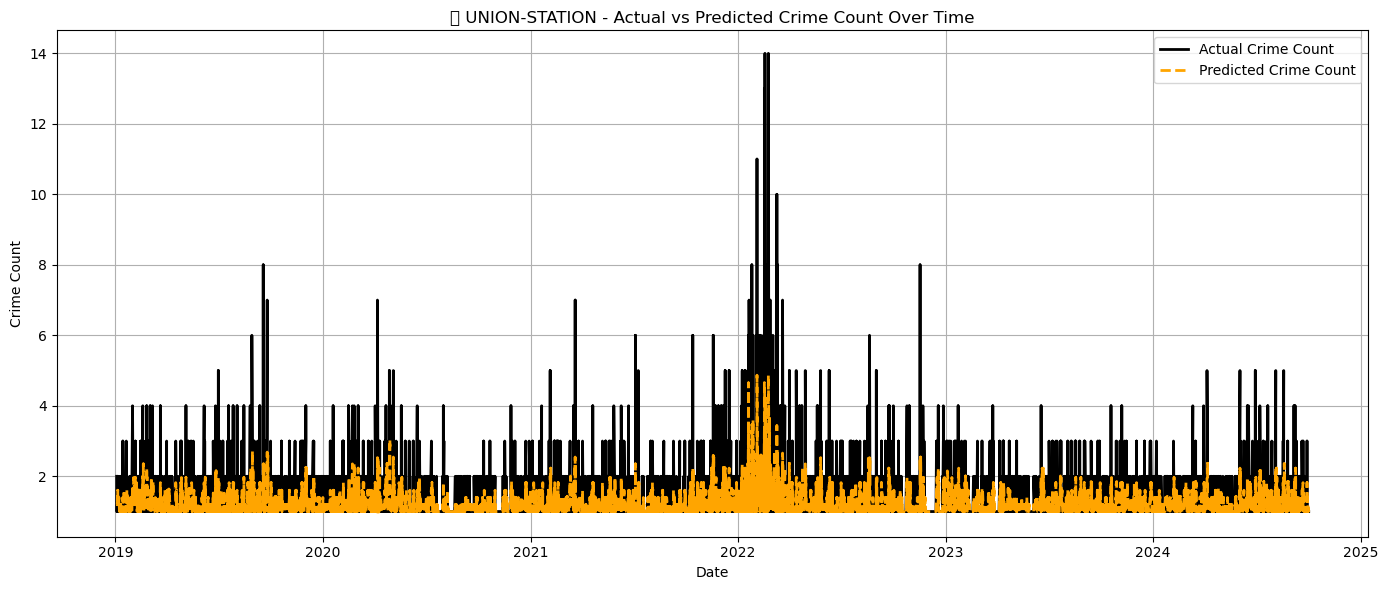

In [56]:
# Choose most frequent neighborhood
top_neigh = df["NEIGHBORHOOD_ID"].value_counts().idxmax()
df_top = df[df["NEIGHBORHOOD_ID"] == top_neigh].sort_values("DATE")

# Plot
plt.figure(figsize=(14, 6))
plt.plot(df_top["DATE"], df_top["crime_count"], label="Actual Crime Count", color="black", linewidth=2)
plt.plot(df_top["DATE"], df_top["predicted_crime_count"], label="Predicted Crime Count", color="orange", linestyle="--", linewidth=2)
plt.title(f"📍 {top_neigh.upper()} - Actual vs Predicted Crime Count Over Time")
plt.xlabel("Date")
plt.ylabel("Crime Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/s0/9c8j0gnd1_l2cgnr9wq06b7r0000gn/T/ipykernel_84228/2477635602.py:9: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/Users/Intel/Desktop/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


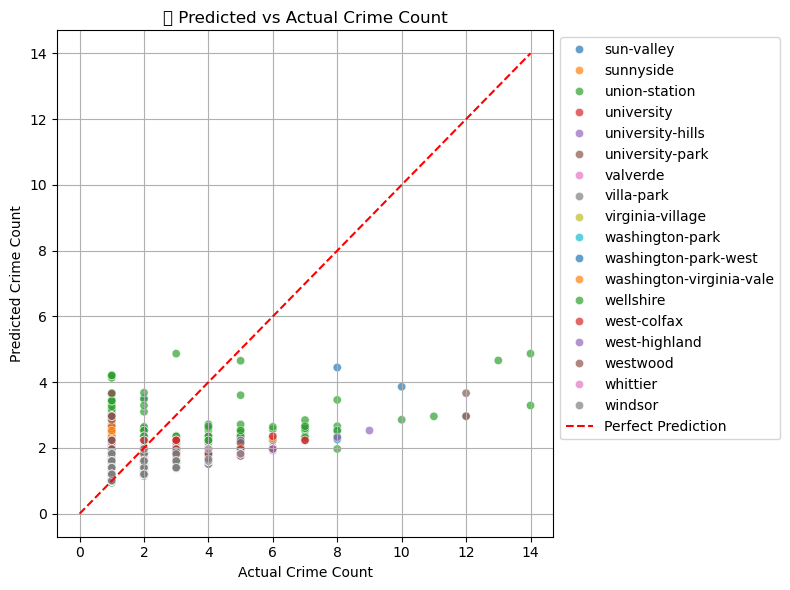

In [57]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="crime_count", y="predicted_crime_count", hue="NEIGHBORHOOD_ID", palette="tab10", alpha=0.7)
plt.plot([0, df["crime_count"].max()], [0, df["crime_count"].max()], 'r--', label="Perfect Prediction")
plt.title("🎯 Predicted vs Actual Crime Count")
plt.xlabel("Actual Crime Count")
plt.ylabel("Predicted Crime Count")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/s0/9c8j0gnd1_l2cgnr9wq06b7r0000gn/T/ipykernel_84228/3459111801.py:9: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/Users/Intel/Desktop/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


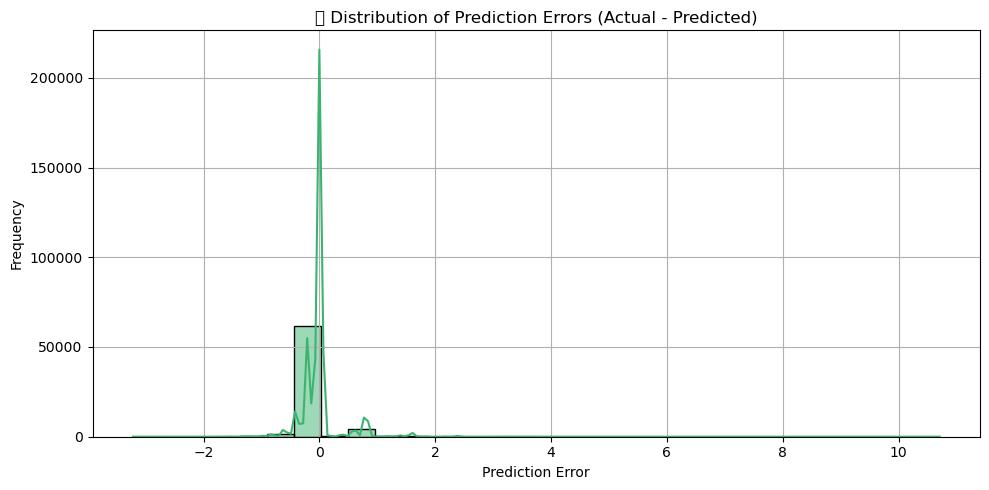

In [58]:
df["error"] = df["crime_count"] - df["predicted_crime_count"]

plt.figure(figsize=(10, 5))
sns.histplot(df["error"], bins=30, kde=True, color="mediumseagreen", edgecolor="black")
plt.title("📊 Distribution of Prediction Errors (Actual - Predicted)")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()
